In [150]:
from google.cloud import bigquery
%load_ext google.cloud.bigquery
client = bigquery.Client(project = "rental-prod")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/Users/tle/.pyenv/versions/amortizations_project/lib/python3.8/site-packages/google/auth/_default.py:79: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [154]:
%%bigquery df
-- Garment Amortizations
-- Spine table: You will have to make a table that get everyday (day 1, 2, 3) and their garment_id
with date_of_garment as
(
select garment_id, event_date
from `rental-prod.nuuly_reporting.amortizations`, unnest(detail)
where event_type = "Garment Create"  
)
, spine as
(
select garment_id, date, abs(date_diff(event_date, date, day)) as time_from_received
from date_of_garment
left join `rental-prod.nuuly_reporting.fiscal_dates` on date > event_date
where date <= current_date and date >= '2019-07-01'
order by date  
)
-- Everytime a customer rent the garment, we add the amortized_cost up
-- Get amortized_cost
, amortized_cost as
(
select garment_id, event_type, event_date, unit_cost, amortized_cost
from `rental-prod.nuuly_reporting.amortizations`, unnest(detail)
where event_type not like '%Transfer%'
)
, sum_amortized_cost_to_spine as
(
select s.garment_id, date, time_from_received, ra.unit_cost, coalesce(sum(amortized_cost) over(partition by s.garment_id order by date rows between unbounded preceding and current row),0) as cumulative_amortized_cost
from spine s
left join amortized_cost a on event_date = date and a.garment_id = s.garment_id
left join `rental-prod.nuuly_reporting.amortizations` ra on ra.garment_id = s.garment_id
order by date
)
-- Join with the product table to get the class and the price_brand
, class_and_price_band as
(
select distinct garment_id, skuid as sku_id, nuuly_class_name, price_band, date, time_from_received, unit_cost, cumulative_amortized_cost
from `rental-prod.nuuly_messages.fingerprint_events`
left join sum_amortized_cost_to_spine on garment_id = garmentid
left join `rental-prod.nuuly_reporting.products` on skuid = sku_id
order by date  
)
select distinct nuuly_class_name, time_from_received, price_band, sum(unit_cost) as total_unit_cost, sum(cumulative_amortized_cost) as total_amortized_cost, (1 - safe_divide(sum(abs(cumulative_amortized_cost)),sum(unit_cost))) as percentage_amortized
from class_and_price_band
group by nuuly_class_name, time_from_received, price_band
order by nuuly_class_name, time_from_received, price_band

/Users/tle/.pyenv/versions/amortizations_project/lib/python3.8/site-packages/google/cloud/bigquery/job/query.py:1683: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Users/tle/.pyenv/versions/amortizations_project/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1942: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [153]:
df

,nuuly_class_name,time_from_received,price_band,total_unit_cost,total_amortized_cost,percentage_amortized
0,None,1,None,3703.0,0.0000,1.000000
1,None,2,None,3703.0,0.0000,1.000000
2,None,3,None,3703.0,0.0000,1.000000
3,None,4,None,3703.0,0.0000,1.000000
4,None,5,None,3703.0,0.0000,1.000000
...,...,...,...,...,...,...
55732,Vintage Tops,1050,Better,2495.0,-2386.4587,0.043504
55733,Vintage Tops,1050,Good,1203.0,-1154.2500,0.040524
55734,Vintage Tops,1051,Best,3505.0,-3191.8751,0.089337
55735,Vintage Tops,1051,Better,2495.0,-2386.4587,0.043504


In [143]:
df['nuuly_class_name'] = pd.to_numeric(df['nuuly_class_name'], errors='coerce')
df['price_band'] = pd.to_numeric(df['price_band'], errors='coerce')

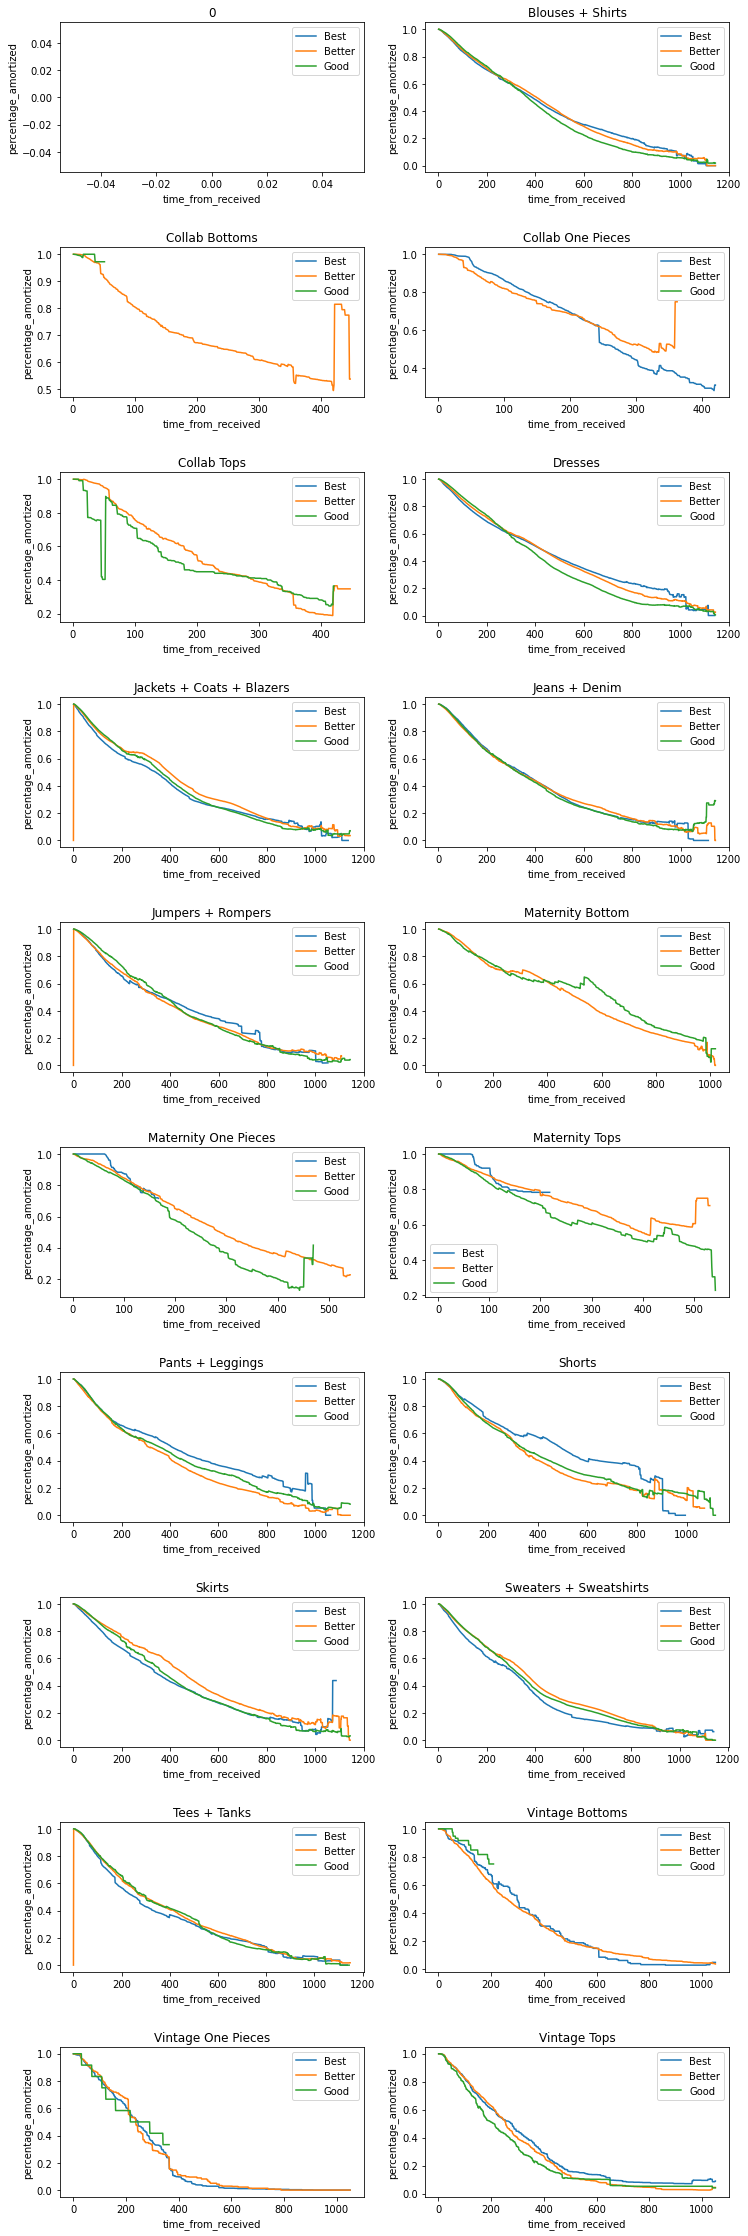

In [216]:
test_df = df.fillna(0)
_, axs = plt.subplots(nrows=10, ncols=2, figsize=(12,40)) #making subplots and fetch axis #make 10 rows and 2 columns for the plots
plt.subplots_adjust(hspace=0.5) #make space between the subplots 

price_band = test_df['price_band'].unique() # getting unique price_band
nuuly_class = test_df['nuuly_class_name'].unique() #getting unique price_band #unique: return a numpy array of unique nuuly_class_name values

for nuuly_class_name, ax in zip(nuuly_class, axs.ravel()):  #zip function: for each nuuly_class, you assign it to one axis (in one graph) #ravel: unravel the axis to match the nully_class to the axis
    class_df = test_df[test_df["nuuly_class_name"] == nuuly_class_name] # match the nuuly_class_name (next to for) to the nuuly_class_name from the data frame to get the data
    for price_band in price_bands:
        class_df.query("price_band==@price_band").plot(ax=ax, x= 'time_from_received', y='percentage_amortized', label = price_band) # plot the data we got from the prev for loop by price_band
    ax.set_title(nuuly_class_name)
    ax.set_xlabel("time_from_received") 
    ax.set_ylabel("percentage_amortized") 

plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'ravel'

TypeError: float() argument must be a string or a number, not 'NAType'

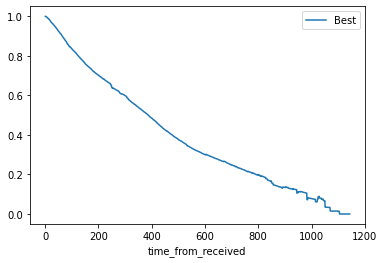

In [88]:
#a = df[df['nuuly_class_name'] == 'Blouses + Shirts']

#Make Variables from dataframe columns
nuuly_class_name = df['nuuly_class_name']
time_from_received = df['time_from_received']
price_band = df['price_band']
percentage_amortized = df['percentage_amortized']

#Set up figure
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Nuuly_class_name')
ax1.set_xlabel("time_from_received")
ax1.set_ylabel("percentage_amortized")

fig, ax = plt.subplots()
for price_band, group in df.groupby('price_band'):
    group.plot(x='time_from_received', y='percentage_amortized', ax=ax, label=price_band)